# Practical Machine Learning for Physicists
## Week 2 Exercise - Part 2
## Deadline Monday 9th November at 12pm (Noon)

For both of these tasks we want you to implement autoencoder networks that:
- Train on randomly generated circles (using the circle_generator function below)
- Use 27x27 pixel images
- Use no more than 30,000 randomly generated samples (e.g. batchsize 30 and 1000 steps, or batchsize 1000 and 30 steps, or anywhere inbetween) in training the final networks for each task
- Use the mean_squared_error loss function
- Fulfil the network size requirement listed in the task (can be verifired using the print_layers function, after the network is partially trained)

### Task 1:
Implement any network design, but the bottleneck must contain no more than 9 neurons.

### Task 2:
Implement any network design, but the bottleneck must contain no more than 3 neurons.


In [1]:
### Importing all the necessary modules ###

import matplotlib.pyplot as plt
import numpy as np
import math
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense


#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

#Useful for debugging problems
print(tf.__version__)

2.3.1


In [2]:
#A big messy function to do the training
# model -- our keras neural model autoencoder
# image_generator -- a function to generate random images for the training (see below for examples)
# img_size -- the size of our image in pixels
# batchsize -- the number of images to include in each training batch
# steps -- the number of steps taken in the training
#
# returns an array of the costs
def generate_and_train(model,image_generator,img_size,batchsize,steps):
   
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    #y_test=np.zeros([1,pixels,pixels,1])
    #y_test[:,:,:,0]=image_generator(1,x,y)
    
    #Now create the empty arrays for the images and cost
    y_in=np.zeros([batchsize,img_size,img_size,1])
    y_target=np.zeros([batchsize,img_size,img_size,1])
    cost=np.zeros(steps)
    
    #Loop through the steps, get a random batch of samples, train the model, repeat
    for k in range(steps):
        # produce samples:
        y_in[:,:,:,0]=image_generator(batchsize,x,y)
        y_target=np.copy(y_in) # autoencoder wants to reproduce its input!
        
        # do one training step on this batch of samples:
        cost[k]=model.train_on_batch(y_in,y_target)
    
    return cost,y_target

def get_test_image(image_generator,img_size):
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    y_test=np.zeros([1,img_size,img_size,1])
    y_test[:,:,:,0]=image_generator(1,x,y)
    return y_test

# A function to generate and plot a single test image and the output of our model
# only to be called after training the model
def plot_test_image(model,image_generator,img_size):
    #Get random test image
    y_test=get_test_image(image_generator,img_size)
    
    #Create the output image
    y_test_out=model.predict_on_batch(y_test)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(y_test[0,:,:,0],origin='lower')
    ax[0].set_title("Input")
    ax[1].imshow(y_test_out[0,:,:,0],origin='lower')
    ax[1].set_title("Output")
    
def print_layers(network, y_in):
    """
    Call this on some test images y_in, to get a print-out of
    the layer sizes. Shapes shown are (batchsize,pixels,pixels,channels).
    After a call to the visualization routine, y_target will contain
    the last set of training images, so you could feed those in here.
    """
    layer_features=get_layer_activations(network,y_in)
    #print(layer_features)
    for idx,feature in enumerate(layer_features):
        s=np.shape(feature)
        print("Layer "+str(idx)+": "+str(s[1]*s[2]*s[3])+" neurons / ", s)

def get_layer_activation_extractor(network):
    #print(network.inputs)
    #for layer in network.layers:
    #    print(layer.output)
    return(keras.Model(inputs=network.inputs,
                            outputs=[layer.output for layer in network.layers]))

def get_layer_activations(network, y_in):
    """
    Call this on some test images y_in, to get the intermediate 
    layer neuron values. These are returned in a list, with one
    entry for each layer (the entries are arrays).
    """
    extractor=get_layer_activation_extractor(network)
    #print(extractor)
    layer_features = extractor(y_in)
    return layer_features
    

## Circle generator


In [3]:
# A simple image generator that returns an array of batchsize images
# each image has a size of x * y pixels
# in this image each image has a randomly placed circle (and the circle is of random size)
def circle_generator(batchsize,x,y):
    R=np.random.uniform(size=batchsize)
    x0=np.random.uniform(size=batchsize,low=-1,high=1)
    y0=np.random.uniform(size=batchsize,low=-1,high=1)
    return( 1.0*((x[None,:,:]-x0[:,None,None])**2 + (y[None,:,:]-y0[:,None,None])**2 < R[:,None,None]**2) )


## Making the Autoencoder

Our autoencoder is built from 2 parts:

Encoder: Compresses the image down to a lower dimensional representation  
Decoder: Reconstructs the image back to its original size

## Bottleneck of 9 neurons wide

In [4]:
model2=keras.models.Sequential()
# 3x3 kernel size

## Encoder ##
model2.add(keras.layers.Conv2D(80,5,input_shape=(None,None,1),
               activation="sigmoid",padding='same'))

model2.add(keras.layers.MaxPooling2D(pool_size=(3,3),padding='same')) # down
model2.add(keras.layers.Conv2D(80,5,
               activation="sigmoid",padding='same'))

model2.add(keras.layers.MaxPooling2D(pool_size=(3,3),padding='same')) # down
model2.add(keras.layers.Conv2D(1,3,
               activation="sigmoid",padding='same'))

## Decoder ##
model2.add(keras.layers.UpSampling2D(size=(3,3))) # up
model2.add(keras.layers.Conv2D(80,5,
               activation="sigmoid",padding='same'))

model2.add(keras.layers.UpSampling2D(size=(3,3))) # up
model2.add(keras.layers.Conv2D(80,5,
               activation="sigmoid",padding='same'))

model2.compile(loss='mean_squared_error',
              optimizer='adam')
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 80)    2080      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 80)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 80)    160080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 80)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 1)     721       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, None, None, 1)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 80)    2

We used 8 layers and a bottleneck that is 9 neurons wide.

Text(0, 0.5, 'Cost')

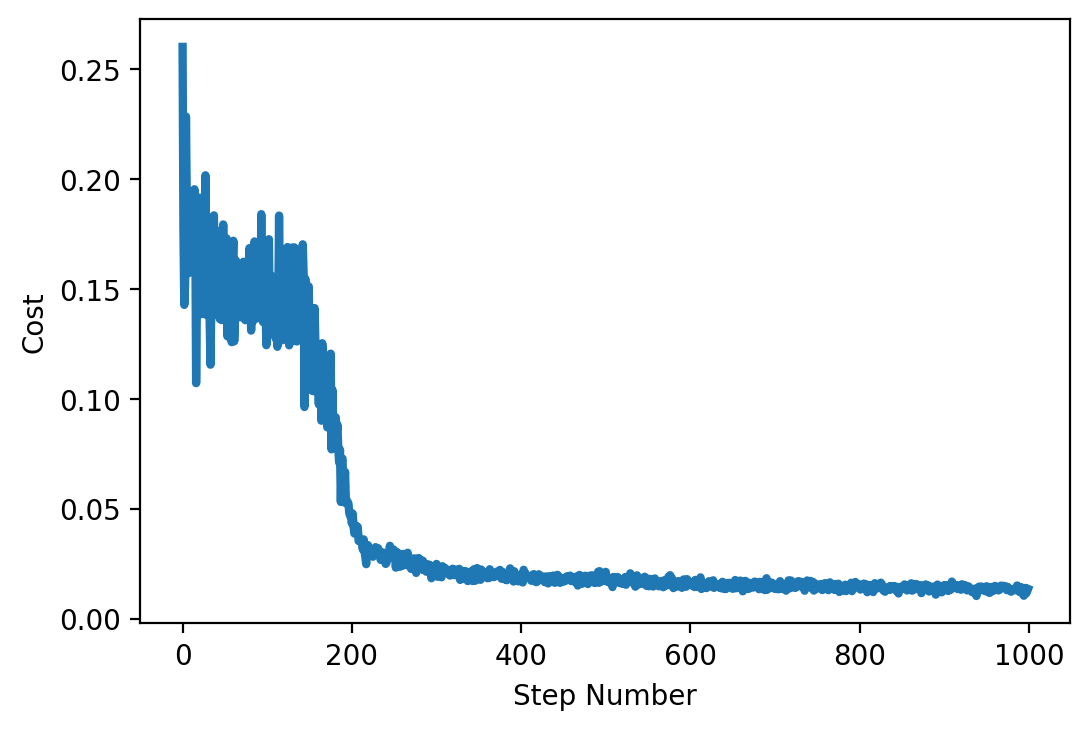

In [5]:
#Now we can do the actual model training
steps=1000
cost,y_target=generate_and_train(model2,circle_generator,img_size=9*3,batchsize=30,steps=steps)
#Plot the cost
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3) 
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")

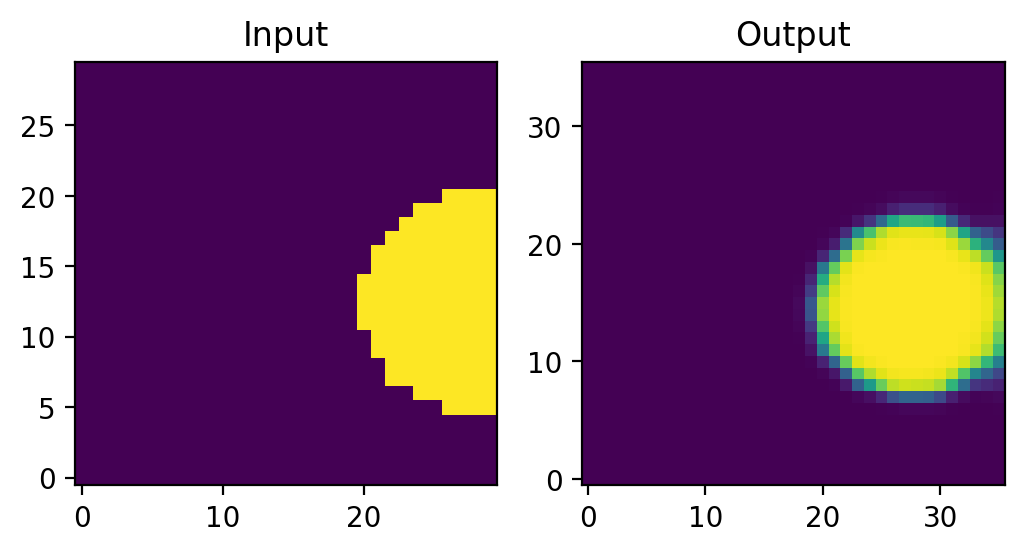

In [6]:
plot_test_image(model2,circle_generator,30)

In [7]:
print_layers(model2,y_target)
print('The final cost is ' + str(cost[-1]))

Layer 0: 58320 neurons /  (30, 27, 27, 80)
Layer 1: 6480 neurons /  (30, 9, 9, 80)
Layer 2: 6480 neurons /  (30, 9, 9, 80)
Layer 3: 720 neurons /  (30, 3, 3, 80)
Layer 4: 9 neurons /  (30, 3, 3, 1)
Layer 5: 81 neurons /  (30, 9, 9, 1)
Layer 6: 6480 neurons /  (30, 9, 9, 80)
Layer 7: 58320 neurons /  (30, 27, 27, 80)
Layer 8: 58320 neurons /  (30, 27, 27, 80)
The final cost is 0.013579619117081165


We used 1000 steps and a batchsize of 30 as per the requirements.  
The final cost beats the target cost of 0.02.  
The sigmoid activations were kept as they seemed to be more consistent overall in creating good images when compared to relu activations.

## Bottleneck of 3 neurons wide

In order to squeeze the bottleneck to 3 neurons, an extra MaxPooling2D and UpSampling2D layer was added.

In [8]:
model3=keras.models.Sequential()
# 3x3 kernel size
model3.add(keras.layers.Conv2D(80,5,input_shape=(None,None,1),
               activation="sigmoid",padding='same'))

model3.add(keras.layers.MaxPooling2D(pool_size=(3,3),padding='same')) # down
model3.add(keras.layers.Conv2D(80,5,
               activation="sigmoid",padding='same'))

model3.add(keras.layers.MaxPooling2D(pool_size=(3,3),padding='same')) # down
model3.add(keras.layers.Conv2D(80,3,
               activation="sigmoid",padding='same'))

model3.add(keras.layers.MaxPooling2D(pool_size=(3,3),padding='same')) # down
model3.add(keras.layers.Conv2D(3,1,
               activation="sigmoid",padding='same'))

model3.add(keras.layers.UpSampling2D(size=(3,3))) # up
model3.add(keras.layers.Conv2D(80,5,
               activation="sigmoid",padding='same'))

model3.add(keras.layers.UpSampling2D(size=(3,3))) # up
model3.add(keras.layers.Conv2D(80,5,
               activation="sigmoid",padding='same'))

model3.add(keras.layers.UpSampling2D(size=(3,3))) # up
model3.add(keras.layers.Conv2D(80,5,
               activation="sigmoid",padding='same'))

model3.compile(loss='mean_squared_error',
              optimizer='adam')
model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, None, None, 80)    2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 80)    0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 80)    160080    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, None, None, 80)    0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 80)    57680     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, None, None, 80)    0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, None, 3)    

Text(0, 0.5, 'Cost')

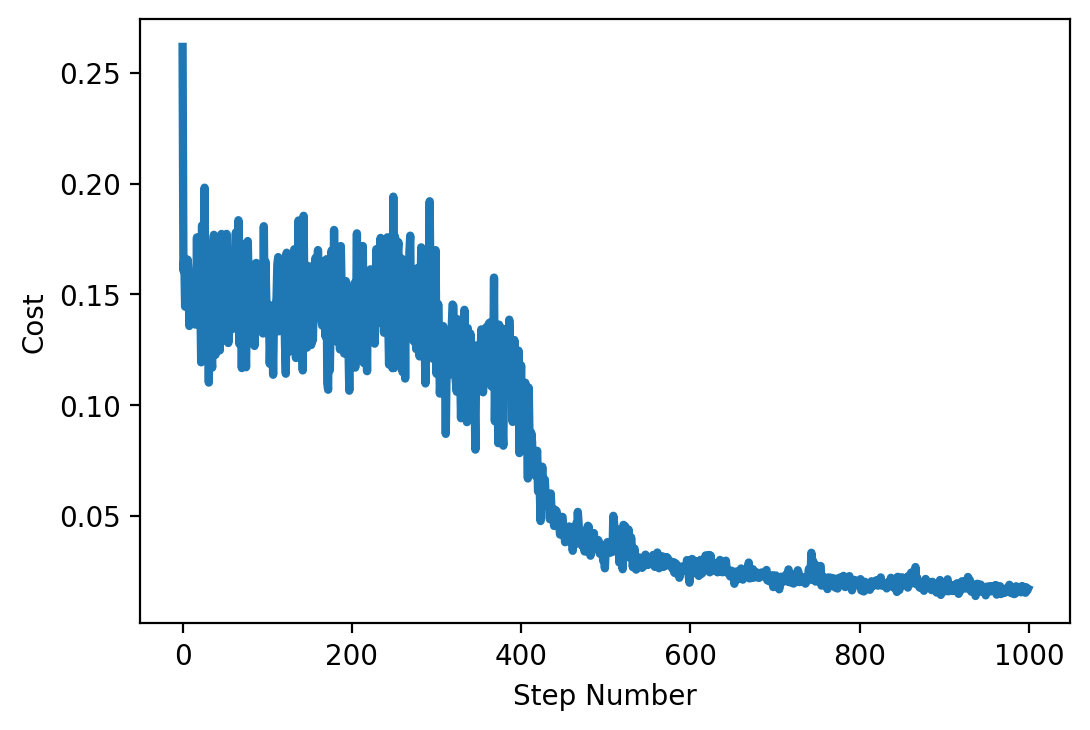

In [9]:
#Now we can do the actual model training
steps=1000
cost,y_target=generate_and_train(model3,circle_generator,img_size=9*3,batchsize=30,steps=steps)
#Plot the cost
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3) 
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")

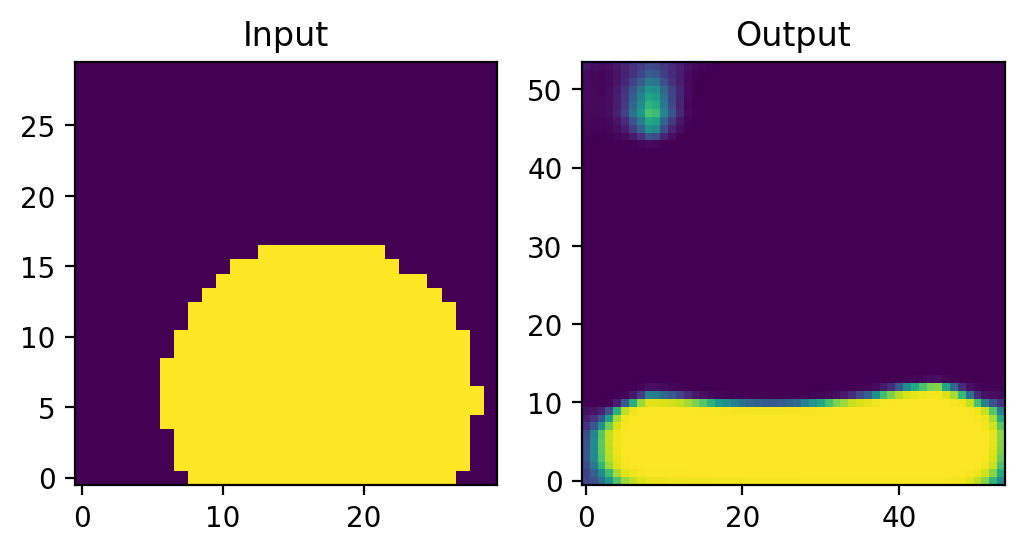

In [10]:
plot_test_image(model3,circle_generator,30)

In [11]:
print_layers(model3,y_target)
print('The final cost is ' + str(cost[-1]))

Layer 0: 58320 neurons /  (30, 27, 27, 80)
Layer 1: 6480 neurons /  (30, 9, 9, 80)
Layer 2: 6480 neurons /  (30, 9, 9, 80)
Layer 3: 720 neurons /  (30, 3, 3, 80)
Layer 4: 720 neurons /  (30, 3, 3, 80)
Layer 5: 80 neurons /  (30, 1, 1, 80)
Layer 6: 3 neurons /  (30, 1, 1, 3)
Layer 7: 27 neurons /  (30, 3, 3, 3)
Layer 8: 720 neurons /  (30, 3, 3, 80)
Layer 9: 6480 neurons /  (30, 9, 9, 80)
Layer 10: 6480 neurons /  (30, 9, 9, 80)
Layer 11: 58320 neurons /  (30, 27, 27, 80)
Layer 12: 58320 neurons /  (30, 27, 27, 80)
The final cost is 0.01703929342329502


The final cost also beats the target cost of 0.02 but the images don't seem to be a very accurate reproduction of the input image especially when the circle is generated close to the edge.